In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
train_dir = "/kaggle/input/tuberculosisdaata/TB_Data/Train"
val_dir = "/kaggle/input/tuberculosisdaata/TB_Data/Validation"
test_dir = "/kaggle/input/tuberculosisdaata/TB_Data/Test"


In [3]:
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes


In [4]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    model.to(device)
    best_model = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Train Acc: {correct/len(train_loader.dataset):.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return correct / len(loader.dataset)


In [5]:
convnext_model = models.convnext_tiny(weights=None)
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, 2)
convnext_criterion = nn.CrossEntropyLoss()
convnext_optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)

convnext_model = train_model(convnext_model, convnext_criterion, convnext_optimizer, train_loader, val_loader)


Epoch 1/20: 100%|██████████| 175/175 [03:24<00:00,  1.17s/it]


Epoch 1: Train Acc: 0.8073, Val Acc: 0.9029


Epoch 2/20: 100%|██████████| 175/175 [02:49<00:00,  1.03it/s]


Epoch 2: Train Acc: 0.9011, Val Acc: 0.9186


Epoch 3/20: 100%|██████████| 175/175 [02:46<00:00,  1.05it/s]


Epoch 3: Train Acc: 0.9241, Val Acc: 0.9414


Epoch 4/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 4: Train Acc: 0.9361, Val Acc: 0.9500


Epoch 5/20: 100%|██████████| 175/175 [02:46<00:00,  1.05it/s]


Epoch 5: Train Acc: 0.9475, Val Acc: 0.9300


Epoch 6/20: 100%|██████████| 175/175 [02:45<00:00,  1.06it/s]


Epoch 6: Train Acc: 0.9529, Val Acc: 0.9557


Epoch 7/20: 100%|██████████| 175/175 [02:45<00:00,  1.06it/s]


Epoch 7: Train Acc: 0.9605, Val Acc: 0.9529


Epoch 8/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 8: Train Acc: 0.9682, Val Acc: 0.9671


Epoch 9/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 9: Train Acc: 0.9748, Val Acc: 0.9714


Epoch 10/20: 100%|██████████| 175/175 [02:45<00:00,  1.06it/s]


Epoch 10: Train Acc: 0.9741, Val Acc: 0.9614


Epoch 11/20: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s]


Epoch 11: Train Acc: 0.9739, Val Acc: 0.9614


Epoch 12/20: 100%|██████████| 175/175 [02:45<00:00,  1.06it/s]


Epoch 12: Train Acc: 0.9771, Val Acc: 0.9743


Epoch 13/20: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s]


Epoch 13: Train Acc: 0.9796, Val Acc: 0.9843


Epoch 14/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 14: Train Acc: 0.9782, Val Acc: 0.9814


Epoch 15/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 15: Train Acc: 0.9761, Val Acc: 0.9800


Epoch 16/20: 100%|██████████| 175/175 [02:46<00:00,  1.05it/s]


Epoch 16: Train Acc: 0.9839, Val Acc: 0.9771


Epoch 17/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 17: Train Acc: 0.9812, Val Acc: 0.9686


Epoch 18/20: 100%|██████████| 175/175 [02:44<00:00,  1.06it/s]


Epoch 18: Train Acc: 0.9830, Val Acc: 0.9829


Epoch 19/20: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s]


Epoch 19: Train Acc: 0.9821, Val Acc: 0.9814


Epoch 20/20: 100%|██████████| 175/175 [02:44<00:00,  1.07it/s]


Epoch 20: Train Acc: 0.9861, Val Acc: 0.9829


In [6]:
vit_model = models.vit_b_16(weights=None)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 2)
vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

vit_model = train_model(vit_model, vit_criterion, vit_optimizer, train_loader, val_loader)


Epoch 1/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 1: Train Acc: 0.8466, Val Acc: 0.9014


Epoch 2/20: 100%|██████████| 175/175 [02:32<00:00,  1.15it/s]


Epoch 2: Train Acc: 0.9125, Val Acc: 0.9000


Epoch 3/20: 100%|██████████| 175/175 [02:35<00:00,  1.13it/s]


Epoch 3: Train Acc: 0.9343, Val Acc: 0.9371


Epoch 4/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 4: Train Acc: 0.9498, Val Acc: 0.9429


Epoch 5/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 5: Train Acc: 0.9445, Val Acc: 0.8757


Epoch 6/20: 100%|██████████| 175/175 [02:31<00:00,  1.15it/s]


Epoch 6: Train Acc: 0.9514, Val Acc: 0.9571


Epoch 7/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 7: Train Acc: 0.9548, Val Acc: 0.9329


Epoch 8/20: 100%|██████████| 175/175 [02:47<00:00,  1.05it/s]


Epoch 8: Train Acc: 0.9566, Val Acc: 0.9571


Epoch 9/20: 100%|██████████| 175/175 [02:46<00:00,  1.05it/s]


Epoch 9: Train Acc: 0.9636, Val Acc: 0.9429


Epoch 10/20: 100%|██████████| 175/175 [02:33<00:00,  1.14it/s]


Epoch 10: Train Acc: 0.9580, Val Acc: 0.9671


Epoch 11/20: 100%|██████████| 175/175 [02:35<00:00,  1.13it/s]


Epoch 11: Train Acc: 0.9655, Val Acc: 0.9514


Epoch 12/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 12: Train Acc: 0.9723, Val Acc: 0.9557


Epoch 13/20: 100%|██████████| 175/175 [02:31<00:00,  1.15it/s]


Epoch 13: Train Acc: 0.9646, Val Acc: 0.9543


Epoch 14/20: 100%|██████████| 175/175 [02:28<00:00,  1.17it/s]


Epoch 14: Train Acc: 0.9680, Val Acc: 0.9514


Epoch 15/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 15: Train Acc: 0.9691, Val Acc: 0.9643


Epoch 16/20: 100%|██████████| 175/175 [02:30<00:00,  1.16it/s]


Epoch 16: Train Acc: 0.9663, Val Acc: 0.9571


Epoch 17/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 17: Train Acc: 0.9641, Val Acc: 0.9657


Epoch 18/20: 100%|██████████| 175/175 [02:35<00:00,  1.13it/s]


Epoch 18: Train Acc: 0.9730, Val Acc: 0.9471


Epoch 19/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 19: Train Acc: 0.9709, Val Acc: 0.9571


Epoch 20/20: 100%|██████████| 175/175 [02:29<00:00,  1.17it/s]


Epoch 20: Train Acc: 0.9714, Val Acc: 0.9571


In [17]:
def ensemble_predict(model1, model2, loader):
    all_labels, all_preds, all_probs = [], [], []
    softmax = nn.Softmax(dim=1)

    model1.eval()
    model2.eval()

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Ensemble Predict"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs1 = softmax(model1(inputs))
            outputs2 = softmax(model2(inputs))

            avg_outputs = (outputs1 + outputs2) / 2
            _, preds = torch.max(avg_outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(avg_outputs[:, 1].cpu().numpy())  # Probability for class 1

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [11]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(labels, preds))
print("\nClassification Report:\n", classification_report(labels, preds, target_names=class_names))


Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       350
Tuberculosis       1.00      0.96      0.98       350

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700



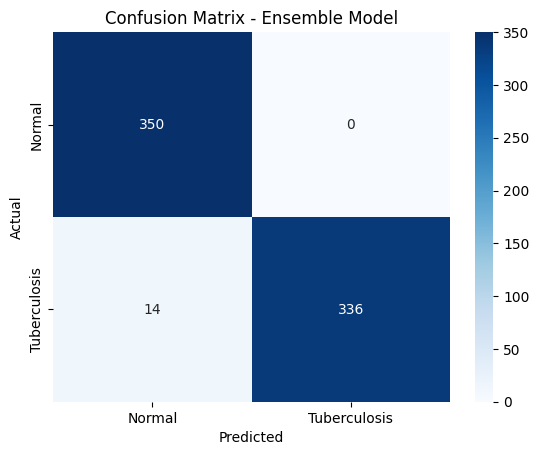

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()


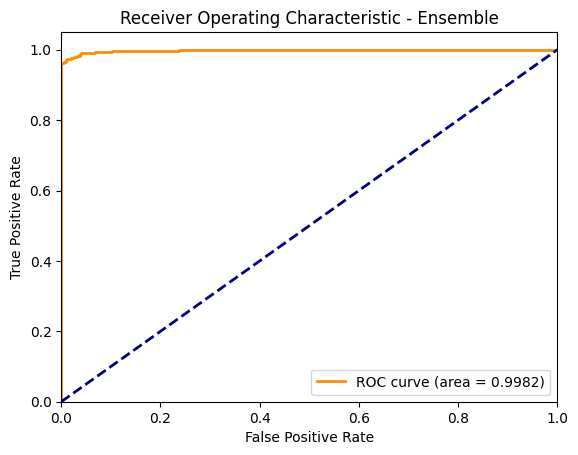

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Ensemble')
plt.legend(loc="lower right")
plt.show()


In [15]:
def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total_loss += loss.item()

    accuracy = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss


In [18]:
labels, preds, probs = ensemble_predict(convnext_model, vit_model, test_loader)


Ensemble Predict: 100%|██████████| 22/22 [00:10<00:00,  2.03it/s]


In [19]:
# ConvNeXt
convnext_train_acc, _ = evaluate(convnext_model, train_loader, convnext_criterion)
convnext_val_acc, _ = evaluate(convnext_model, val_loader, convnext_criterion)

# ViT
vit_train_acc, _ = evaluate(vit_model, train_loader, vit_criterion)
vit_val_acc, _ = evaluate(vit_model, val_loader, vit_criterion)

# Ensemble Test Accuracy
labels, preds, probs = ensemble_predict(convnext_model, vit_model, test_loader)
from sklearn.metrics import accuracy_score
ensemble_test_acc = accuracy_score(labels, preds)

# Print Accuracies
print(f"\n🔢 Accuracy Summary:")
print(f"ConvNeXt - Train Accuracy: {convnext_train_acc*100:.2f}%")
print(f"ConvNeXt - Val Accuracy:   {convnext_val_acc*100:.2f}%")
print(f"ViT       - Train Accuracy: {vit_train_acc*100:.2f}%")
print(f"ViT       - Val Accuracy:   {vit_val_acc*100:.2f}%")
print(f"\n🧠 Ensemble Model - Test Accuracy: {ensemble_test_acc*100:.2f}%")


Ensemble Predict: 100%|██████████| 22/22 [00:10<00:00,  2.03it/s]


🔢 Accuracy Summary:
ConvNeXt - Train Accuracy: 98.80%
ConvNeXt - Val Accuracy:   98.29%
ViT       - Train Accuracy: 97.79%
ViT       - Val Accuracy:   95.71%

🧠 Ensemble Model - Test Accuracy: 98.00%


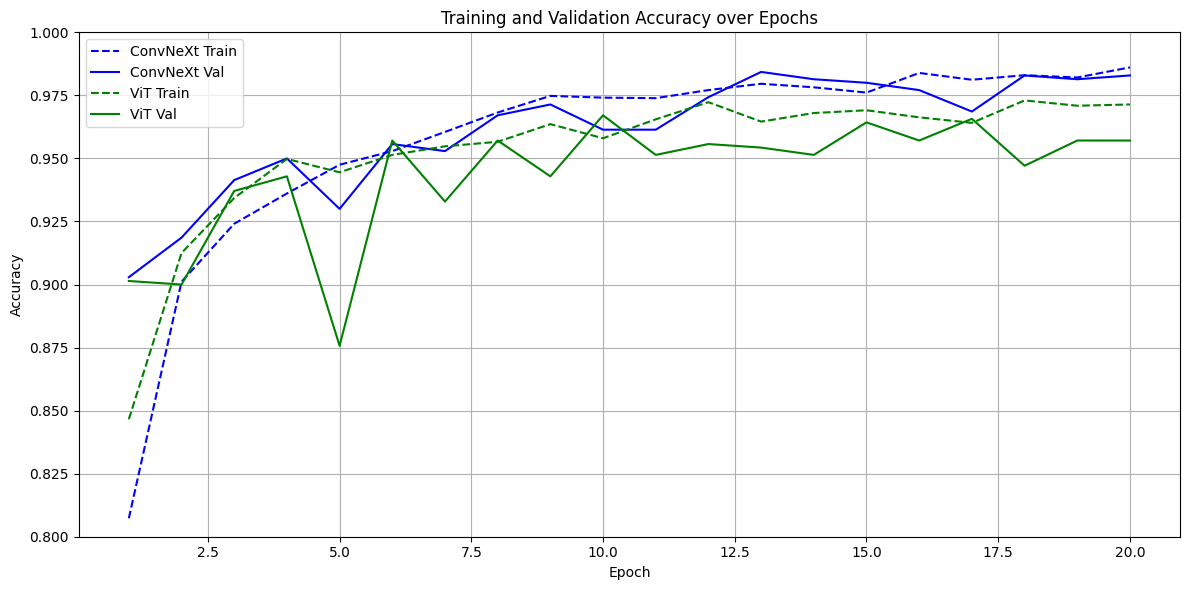

In [28]:
import matplotlib.pyplot as plt

# ConvNeXt accuracies
convnext_train_acc = [
    0.8073, 0.9011, 0.9241, 0.9361, 0.9475, 0.9529, 0.9605, 0.9682, 0.9748, 0.9741,
    0.9739, 0.9771, 0.9796, 0.9782, 0.9761, 0.9839, 0.9812, 0.9830, 0.9821, 0.9861
]
convnext_val_acc = [
    0.9029, 0.9186, 0.9414, 0.9500, 0.9300, 0.9557, 0.9529, 0.9671, 0.9714, 0.9614,
    0.9614, 0.9743, 0.9843, 0.9814, 0.9800, 0.9771, 0.9686, 0.9829, 0.9814, 0.9829
]

# ViT accuracies
vit_train_acc = [
    0.8466, 0.9125, 0.9343, 0.9498, 0.9445, 0.9514, 0.9548, 0.9566, 0.9636, 0.9580,
    0.9655, 0.9723, 0.9646, 0.9680, 0.9691, 0.9663, 0.9641, 0.9730, 0.9709, 0.9714
]
vit_val_acc = [
    0.9014, 0.9000, 0.9371, 0.9429, 0.8757, 0.9571, 0.9329, 0.9571, 0.9429, 0.9671,
    0.9514, 0.9557, 0.9543, 0.9514, 0.9643, 0.9571, 0.9657, 0.9471, 0.9571, 0.9571
]

# Epoch range
epochs = range(1, 21)

# Plotting
plt.figure(figsize=(12, 6))

# ConvNeXt
plt.plot(epochs, convnext_train_acc, 'b--', label='ConvNeXt Train')
plt.plot(epochs, convnext_val_acc, 'b-', label='ConvNeXt Val')

# ViT
plt.plot(epochs, vit_train_acc, 'g--', label='ViT Train')
plt.plot(epochs, vit_val_acc, 'g-', label='ViT Val')

plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.80, 1.00)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# Save ConvNeXt model
torch.save(convnext_model.state_dict(), "convnext_tb.pth")

# Save ViT model
torch.save(vit_model.state_dict(), "vit_tb.pth")


In [22]:
# ConvNeXt
convnext_model = models.convnext_tiny(weights=None)
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, 2)
convnext_model.load_state_dict(torch.load("convnext_tb.pth"))
convnext_model.to(device)
convnext_model.eval()

# ViT
vit_model = models.vit_b_16(weights=None)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 2)
vit_model.load_state_dict(torch.load("vit_tb.pth"))
vit_model.to(device)
vit_model.eval()


<ipython-input-22-3e1930b72967>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  convnext_model.load_state_dict(torch.load("convnext_tb.pth"))
<ipython-input-22-3e1930b72967

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [23]:
torch.save(convnext_model.state_dict(), "/kaggle/working/convnext_tb.pth")
torch.save(vit_model.state_dict(), "/kaggle/working/vit_tb.pth")


In [25]:
import zipfile

with zipfile.ZipFile("/kaggle/working/tb_ensemble_models.zip", "w") as zipf:
    zipf.write("/kaggle/working/convnext_tb.pth")
    zipf.write("/kaggle/working/vit_tb.pth")
